# 1.1 Start

---



In [1]:
# importing some libraries (not all are currently used)

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image
import imageio
import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar

import random

# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/AI4ALL\ Diabetic\ Retinopathy\ Research/Early\ ML\ Model/aptos2019-blindness-detection

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1DwcsYZWFxUskq7gNIgNqPDzvPfHJSdsh/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection


# 2.1 Data Analysis

In [4]:
x_data = np.load('x_train_unfiltered.npy')
y_data = np.load('y_train2.npy')

In [5]:
y_data

array([2, 4, 1, ..., 2, 0, 2])

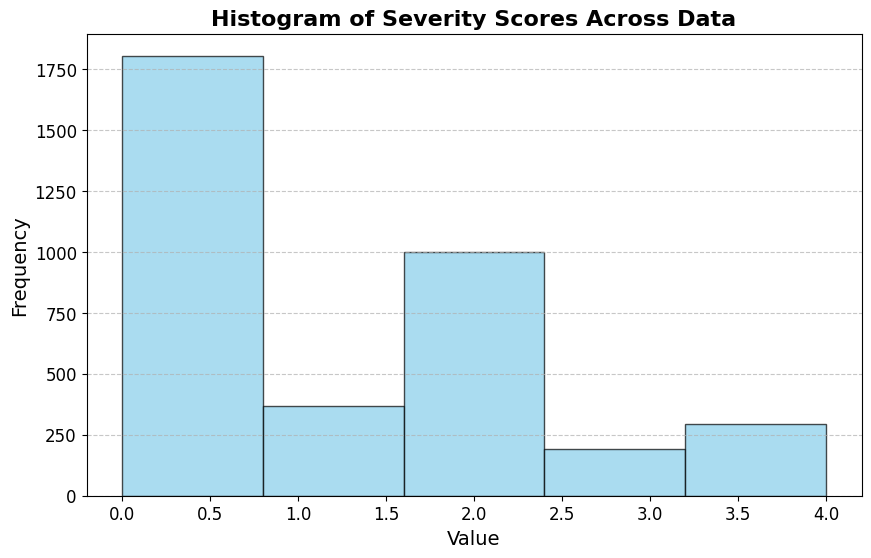

In [6]:
# Create a histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_data, bins=5, edgecolor='black', color='skyblue', alpha=0.7)

# Add titles and labels
plt.title('Histogram of Severity Scores Across Data', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [7]:
import numpy as np

def count_occurrences_bincount(arr):
    # Ensure input is a NumPy array of non-negative integers
    if not np.issubdtype(arr.dtype, np.integer) or np.any(arr < 0):
        raise ValueError("Input array must be a NumPy array of non-negative integers.")

    counts = np.bincount(arr)
    return counts

# Example usage
arr = y_data
counts = count_occurrences_bincount(arr)
print(counts)

[1805  370  999  193  295]


([<matplotlib.patches.Wedge at 0x7b4680e01bd0>,
 [Text(0.024533653067266015, 1.0997263749984245, 'No DR'),
  Text(-1.0593196619831637, -0.29638126414447286, 'Mild'),
  Text(-0.13554444257363468, -1.0916170134655299, 'Moderate'),
  Text(0.8610223192730306, -0.6845732727135142, 'Severe'),
  Text(1.0649610805536351, -0.2754231234047608, 'PR DR')])

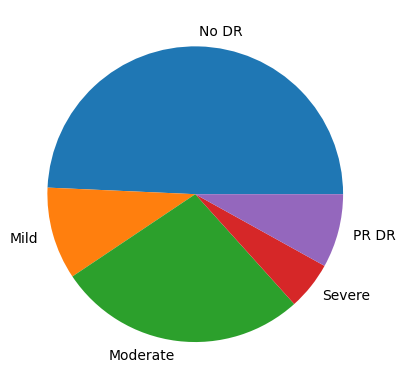

In [8]:
import matplotlib.pyplot as plt

labels = 'No DR', 'Mild', 'Moderate', 'Severe', 'PR DR'
sizes = counts

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)

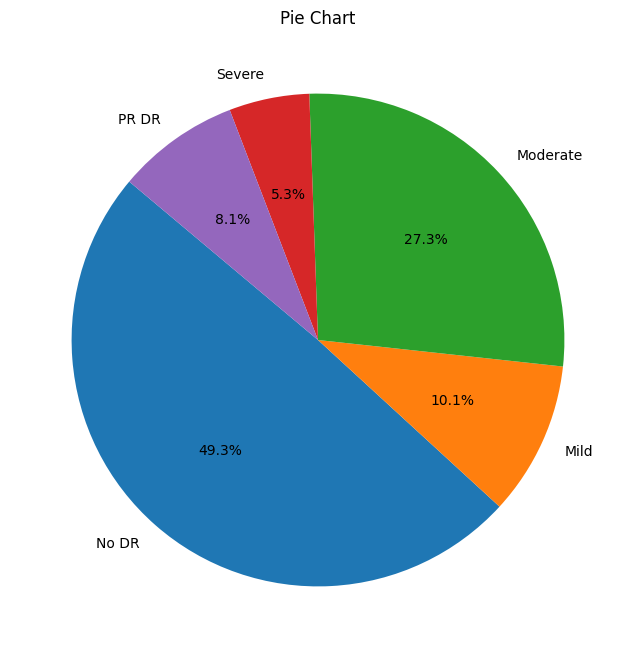

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Example numpy array with data for the pie chart
data = counts
labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'PR DR']


# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: Adjust the figure size
plt.pie(data, labels=[f'{labels[i]}' for i in range(len(data))], autopct='%1.1f%%', startangle=140)

# Title for the pie chart
plt.title('Pie Chart')

# Show the plot
plt.show()

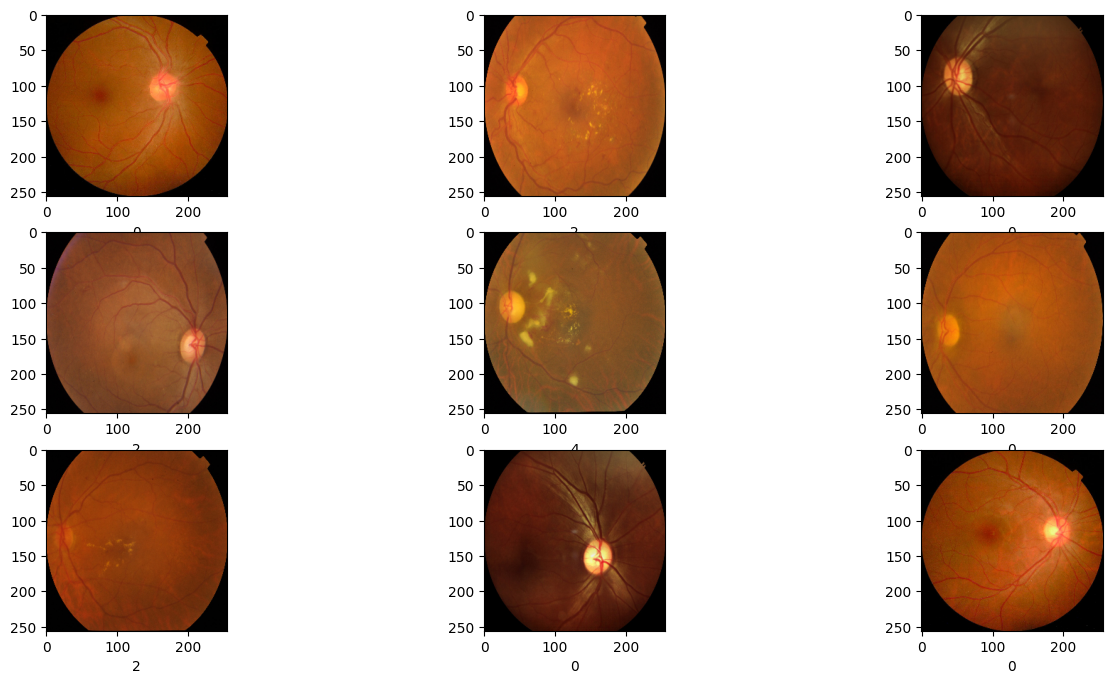

In [10]:
from numpy import random

plt.figure(figsize=(16,8))

arr = random.randint(len(x_data), size=(9))


for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[arr[i]])
  plt.imshow(x_data[arr[i]])



# 3.1 Data Upload

---



In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [12]:
import torch
from torchvision import transforms
from PIL import Image, ImageFilter
import random

class PreprocessedRetinaDataset(Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):

        image = self.x_train[idx]
        label = self.y_train[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


"""transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5,), (0.5,)),
])"""

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.RandomHorizontalFlip(),  # Add random horizontal flipping
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Add Gaussian blur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.batch_norm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.batch_norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.batch_norm4 = nn.BatchNorm2d(128)


        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 14 * 14, 128)
        self.dropout = nn.Dropout(p=0.001)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))

        x = x.view(-1, 128 * 14 * 14)  # Flatten with the correct size
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

model = EnhancedCNN()

In [14]:
# Create datasets and dataloaders
trainset = PreprocessedRetinaDataset(x_train=x_train, y_train=y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

validset = PreprocessedRetinaDataset(x_train=x_val, y_train=y_val, transform=transform)
validloader = DataLoader(validset, batch_size=64, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 5.1 Training

---



In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, num_classes=5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        # Compute the base cross-entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Compute class probabilities from logits
        probs = F.softmax(inputs, dim=1)

        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute the probability assigned to the true class
        pt = torch.sum(probs * targets_one_hot, dim=1)

        # Compute alpha_t
        alpha_t = self.alpha * targets_one_hot + (1 - self.alpha) * (1 - targets_one_hot)

        # Compute the focal loss
        focal_loss = alpha_t * (1 - pt.unsqueeze(1)) ** self.gamma * ce_loss

        # Reduce the loss as specified (mean reduction by default)
        return focal_loss.mean()

In [16]:
#criterion = FocalLoss(alpha = 0.25, gamma=2.0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


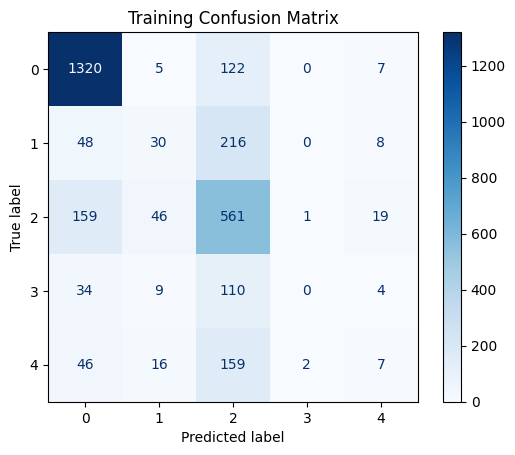

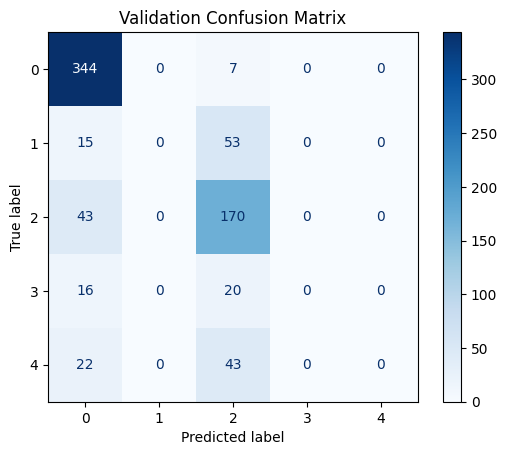

--- 296.5927789211273 seconds ---
Epoch 1: Train Loss: 0.931, Train Accuracy: 65.483%, Valid Loss: 0.862, Valid Accuracy: 70.123%
Train AUROC: 0.783, Train F1: 0.601%, Valid AUROC: 0.814, Valid F1: 0.612%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


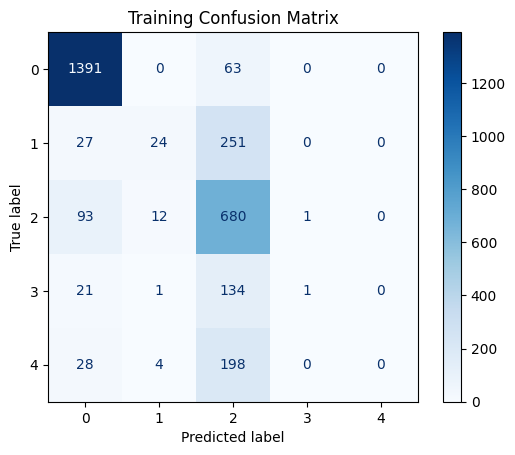

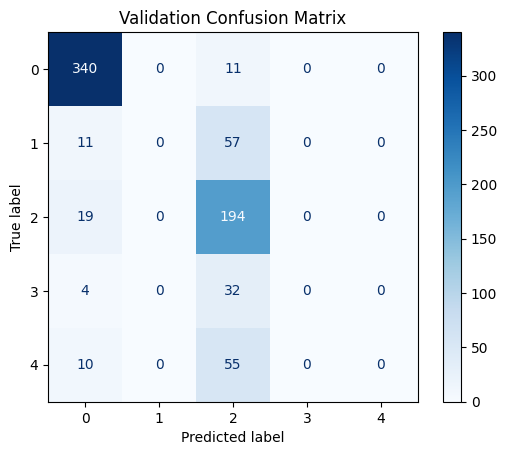

--- 290.84448289871216 seconds ---
Epoch 2: Train Loss: 0.8, Train Accuracy: 71.56%, Valid Loss: 0.792, Valid Accuracy: 72.851%
Train AUROC: 0.83, Train F1: 0.646%, Valid AUROC: 0.841, Valid F1: 0.644%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


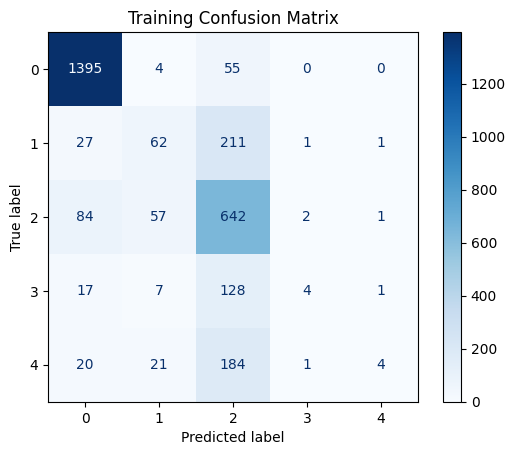

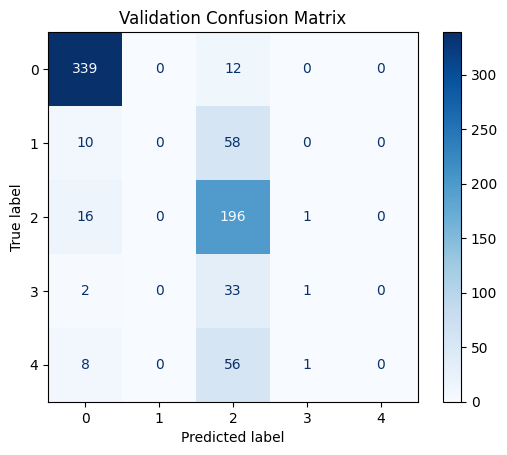

--- 298.126403093338 seconds ---
Epoch 3: Train Loss: 0.755, Train Accuracy: 71.936%, Valid Loss: 0.781, Valid Accuracy: 73.124%
Train AUROC: 0.857, Train F1: 0.667%, Valid AUROC: 0.845, Valid F1: 0.65%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


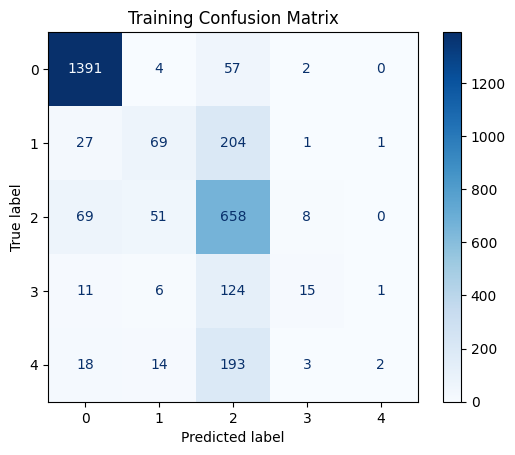

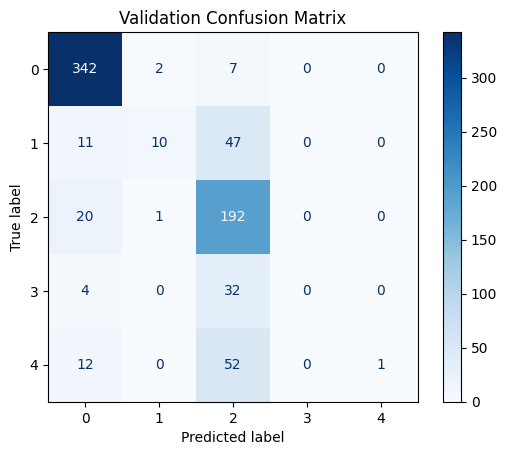

--- 292.61294317245483 seconds ---
Epoch 4: Train Loss: 0.723, Train Accuracy: 72.892%, Valid Loss: 0.788, Valid Accuracy: 74.352%
Train AUROC: 0.873, Train F1: 0.682%, Valid AUROC: 0.851, Valid F1: 0.674%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


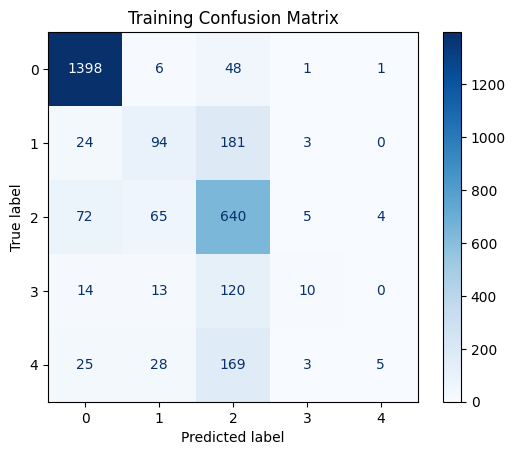

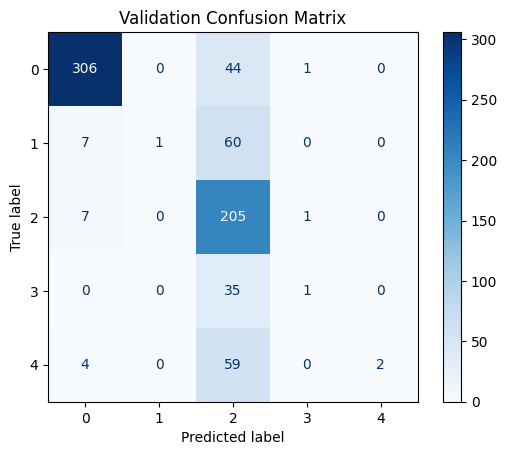

--- 285.51602053642273 seconds ---
Epoch 5: Train Loss: 0.713, Train Accuracy: 73.301%, Valid Loss: 0.809, Valid Accuracy: 70.259%
Train AUROC: 0.876, Train F1: 0.689%, Valid AUROC: 0.85, Valid F1: 0.638%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


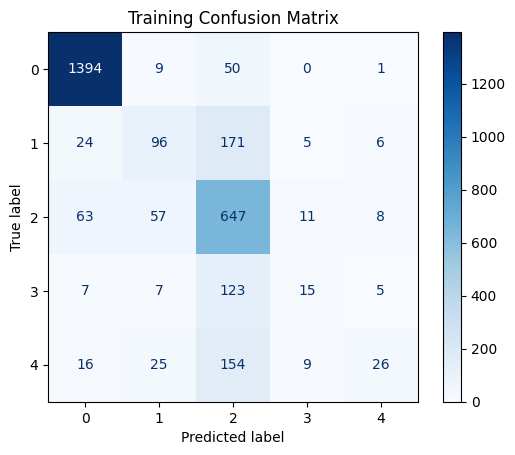

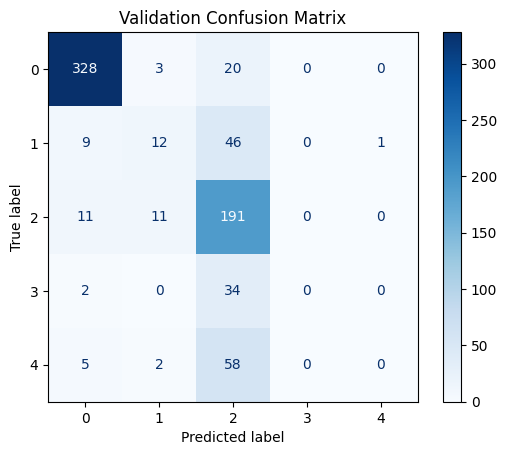

--- 298.02253770828247 seconds ---
Epoch 6: Train Loss: 0.686, Train Accuracy: 74.36%, Valid Loss: 0.809, Valid Accuracy: 72.442%
Train AUROC: 0.889, Train F1: 0.711%, Valid AUROC: 0.859, Valid F1: 0.666%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


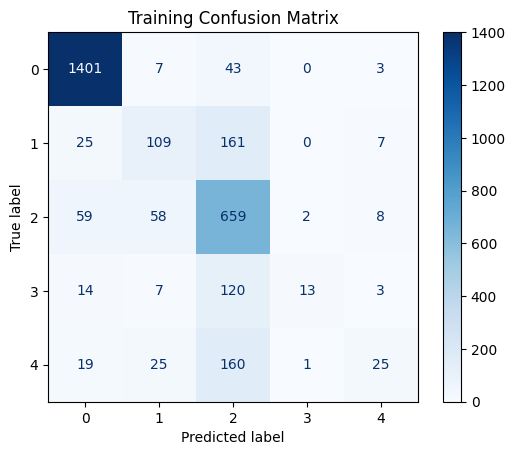

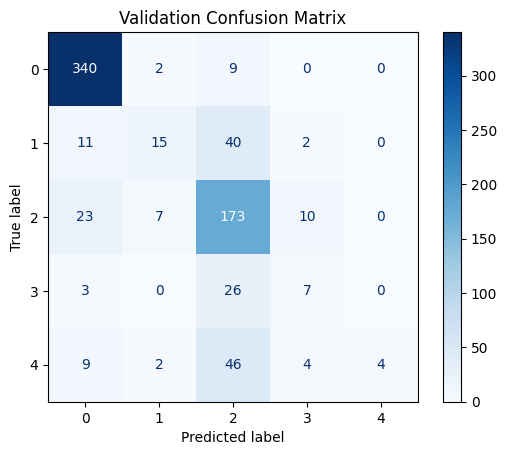

--- 291.9150860309601 seconds ---
Epoch 7: Train Loss: 0.68, Train Accuracy: 75.35%, Valid Loss: 0.747, Valid Accuracy: 73.533%
Train AUROC: 0.892, Train F1: 0.718%, Valid AUROC: 0.863, Valid F1: 0.692%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


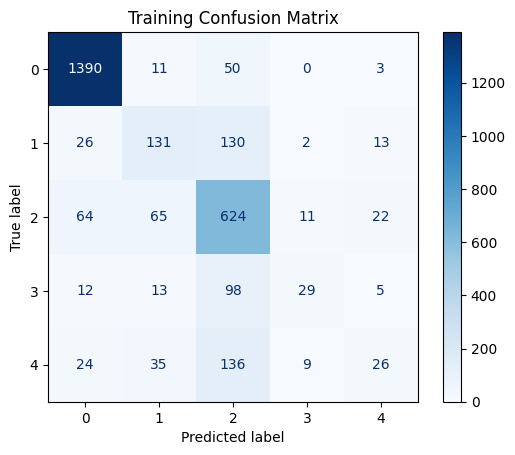

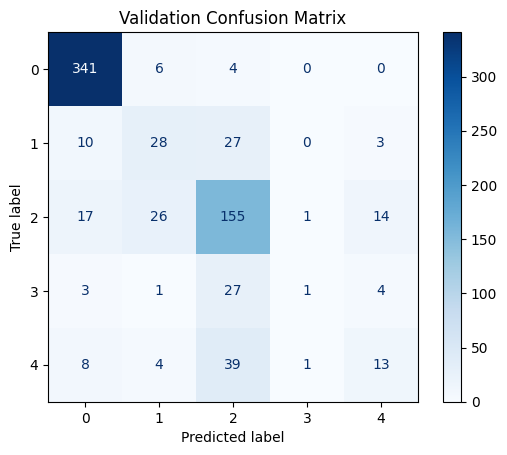

--- 295.2437798976898 seconds ---
Epoch 8: Train Loss: 0.661, Train Accuracy: 75.111%, Valid Loss: 0.74, Valid Accuracy: 73.397%
Train AUROC: 0.898, Train F1: 0.725%, Valid AUROC: 0.871, Valid F1: 0.706%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


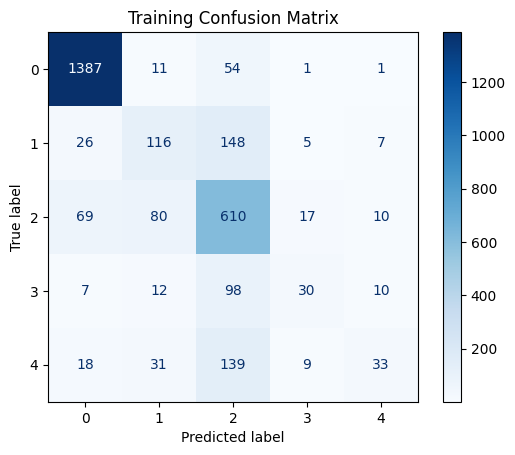

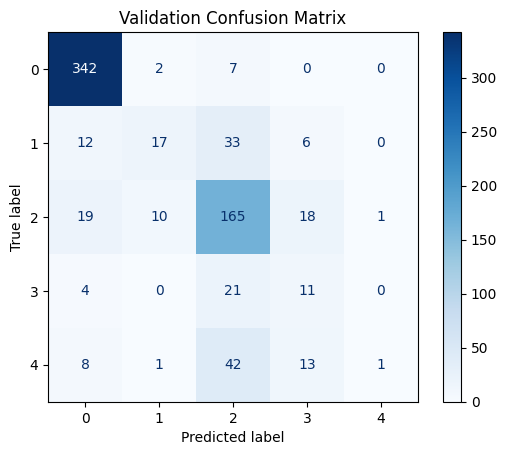

--- 295.62995052337646 seconds ---
Epoch 9: Train Loss: 0.658, Train Accuracy: 74.292%, Valid Loss: 0.778, Valid Accuracy: 73.124%
Train AUROC: 0.898, Train F1: 0.719%, Valid AUROC: 0.865, Valid F1: 0.692%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


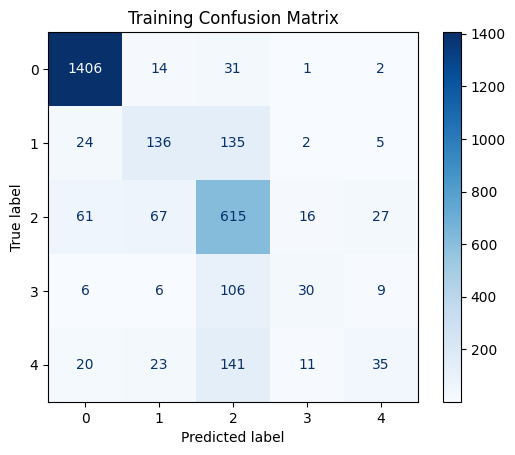

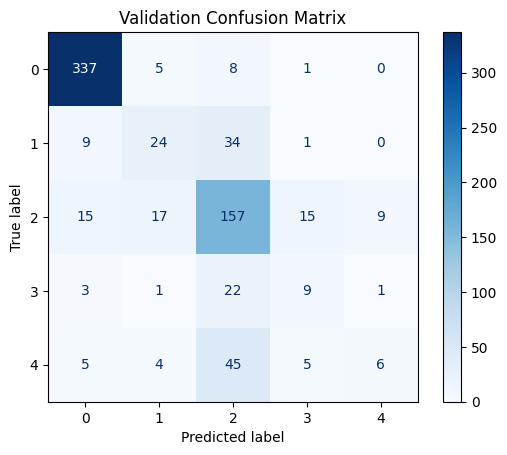

--- 297.5888285636902 seconds ---
Epoch 10: Train Loss: 0.633, Train Accuracy: 75.862%, Valid Loss: 0.734, Valid Accuracy: 72.715%
Train AUROC: 0.905, Train F1: 0.736%, Valid AUROC: 0.87, Valid F1: 0.703%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


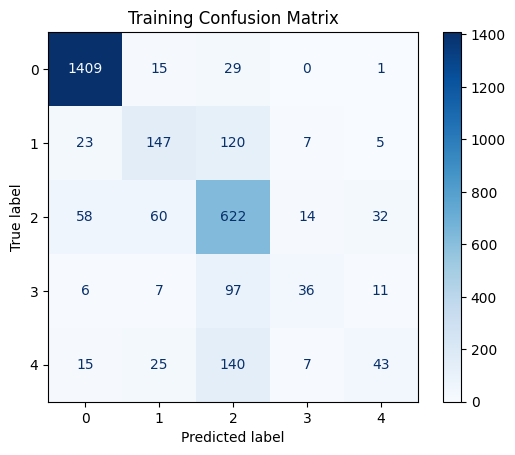

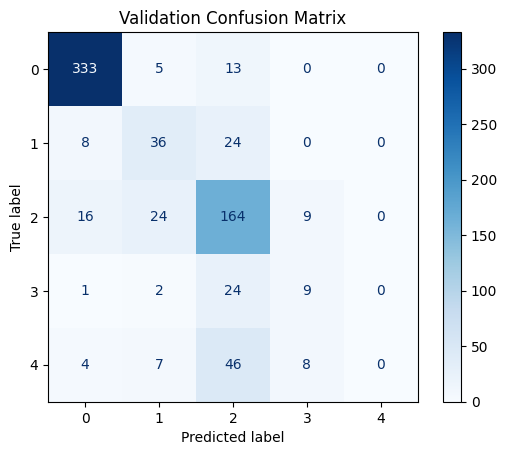

--- 297.7531621456146 seconds ---
Epoch 11: Train Loss: 0.617, Train Accuracy: 77.057%, Valid Loss: 0.763, Valid Accuracy: 73.943%
Train AUROC: 0.911, Train F1: 0.751%, Valid AUROC: 0.868, Valid F1: 0.706%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


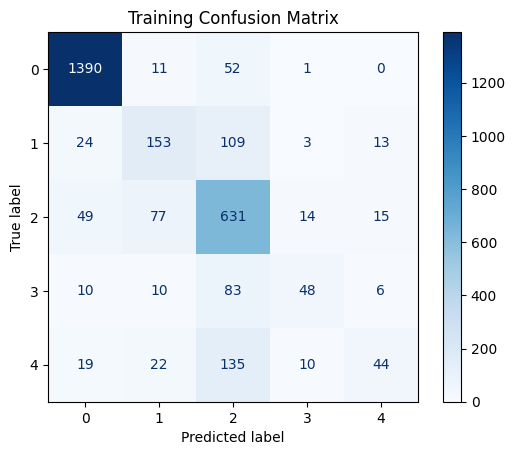

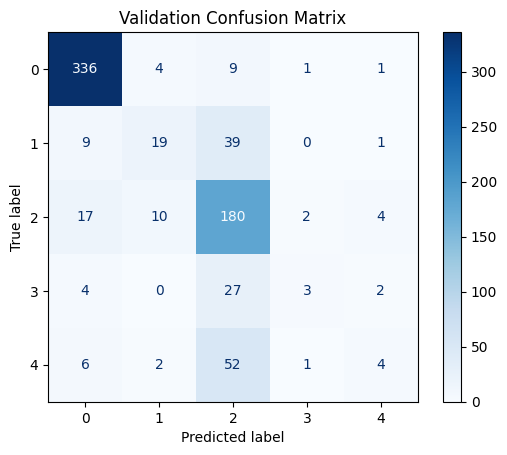

--- 295.90497612953186 seconds ---
Epoch 12: Train Loss: 0.596, Train Accuracy: 77.364%, Valid Loss: 0.729, Valid Accuracy: 73.943%
Train AUROC: 0.919, Train F1: 0.756%, Valid AUROC: 0.871, Valid F1: 0.697%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


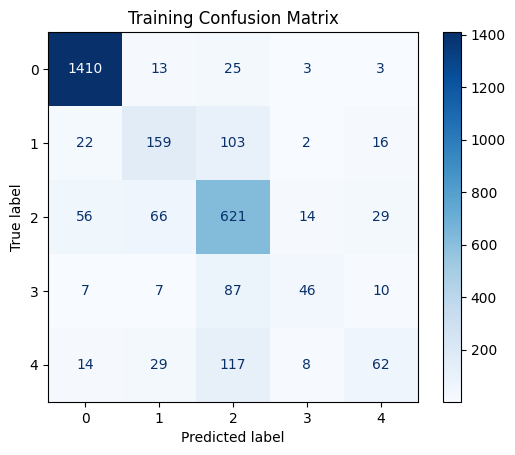

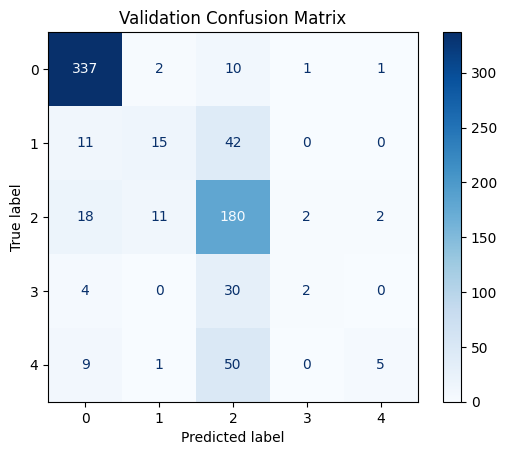

--- 308.28844022750854 seconds ---
Epoch 13: Train Loss: 0.574, Train Accuracy: 78.457%, Valid Loss: 0.748, Valid Accuracy: 73.533%
Train AUROC: 0.923, Train F1: 0.77%, Valid AUROC: 0.869, Valid F1: 0.687%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


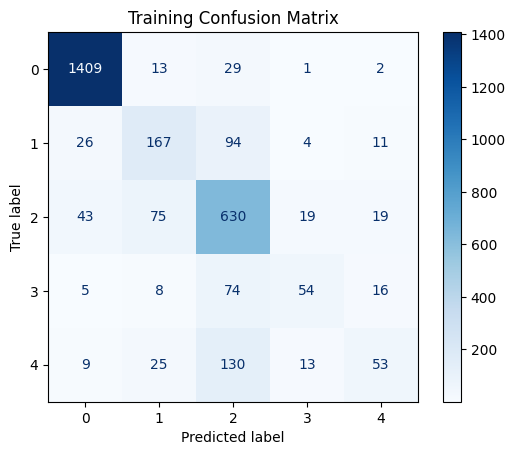

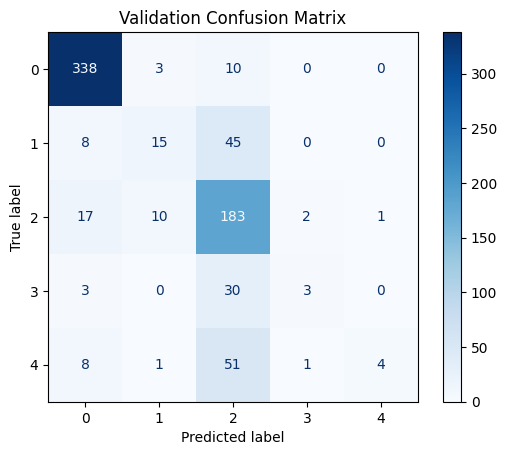

--- 293.5188674926758 seconds ---
Epoch 14: Train Loss: 0.544, Train Accuracy: 78.969%, Valid Loss: 0.774, Valid Accuracy: 74.079%
Train AUROC: 0.933, Train F1: 0.776%, Valid AUROC: 0.875, Valid F1: 0.692%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


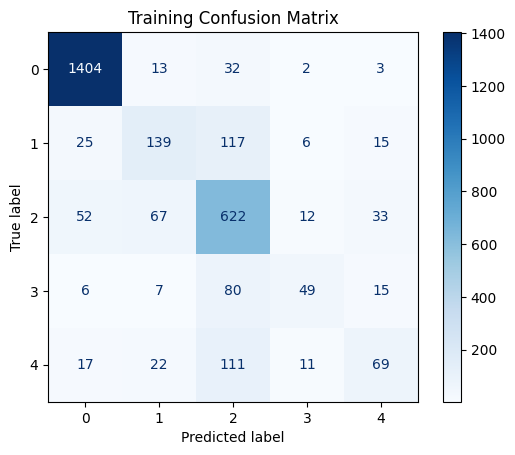

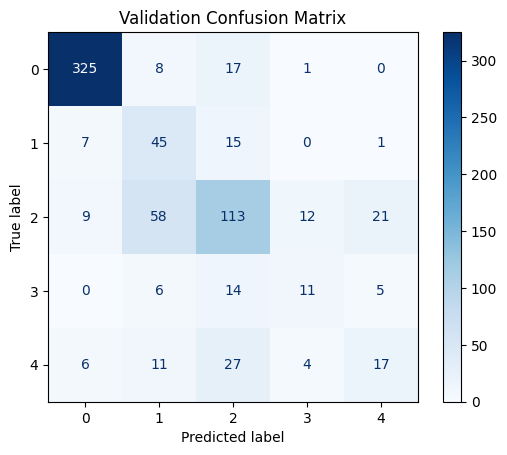

--- 294.98776841163635 seconds ---
Epoch 15: Train Loss: 0.564, Train Accuracy: 77.945%, Valid Loss: 0.803, Valid Accuracy: 69.714%
Train AUROC: 0.929, Train F1: 0.766%, Valid AUROC: 0.866, Valid F1: 0.698%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


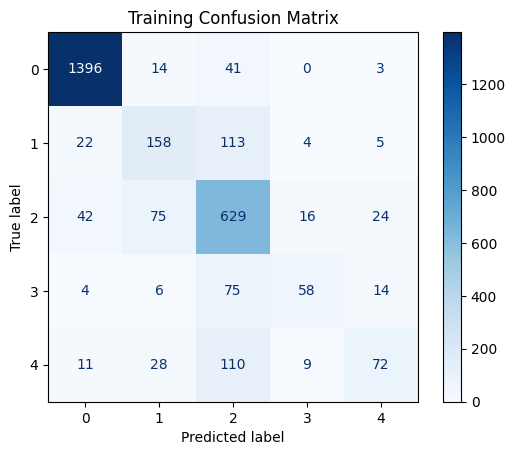

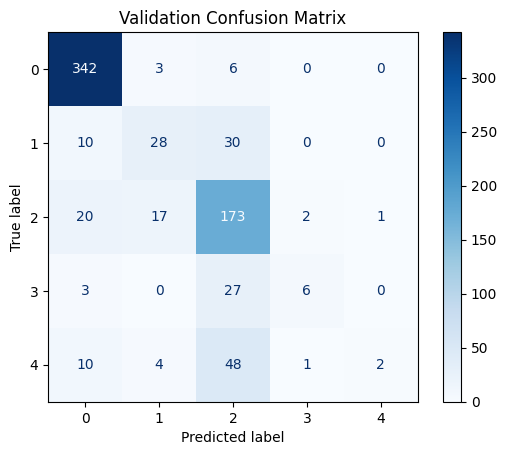

--- 289.94560718536377 seconds ---
Epoch 16: Train Loss: 0.537, Train Accuracy: 78.969%, Valid Loss: 0.772, Valid Accuracy: 75.171%
Train AUROC: 0.935, Train F1: 0.78%, Valid AUROC: 0.877, Valid F1: 0.709%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


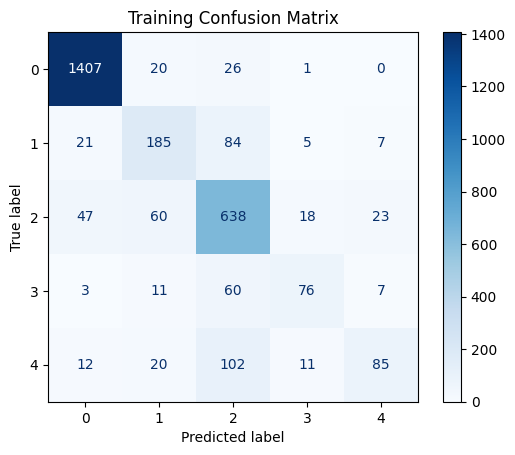

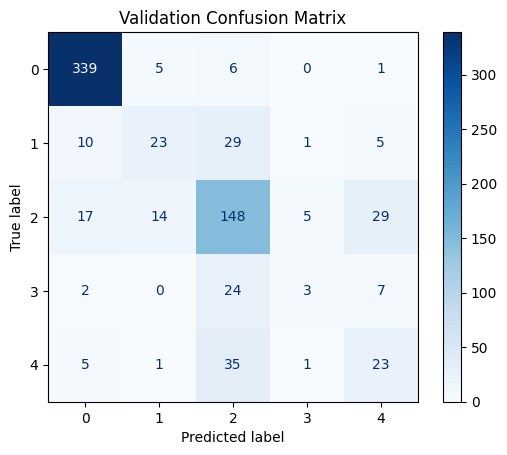

--- 292.9037227630615 seconds ---
Epoch 17: Train Loss: 0.508, Train Accuracy: 81.632%, Valid Loss: 0.741, Valid Accuracy: 73.124%
Train AUROC: 0.941, Train F1: 0.809%, Valid AUROC: 0.87, Valid F1: 0.714%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


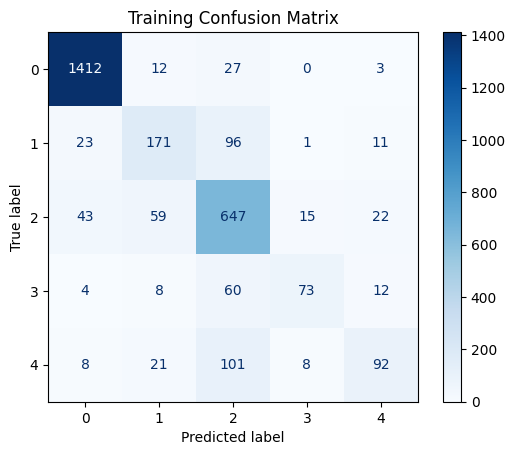

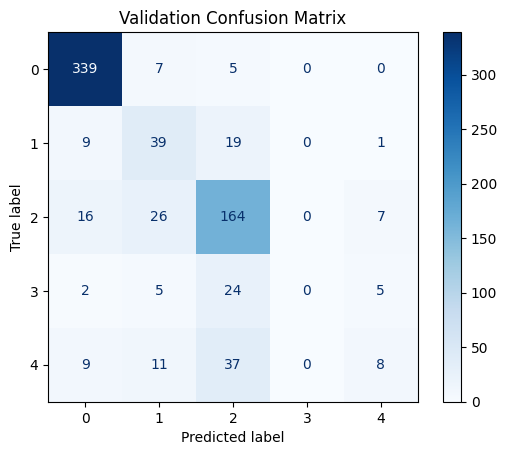

--- 287.19642305374146 seconds ---
Epoch 18: Train Loss: 0.484, Train Accuracy: 81.769%, Valid Loss: 0.792, Valid Accuracy: 75.034%
Train AUROC: 0.949, Train F1: 0.81%, Valid AUROC: 0.872, Valid F1: 0.716%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


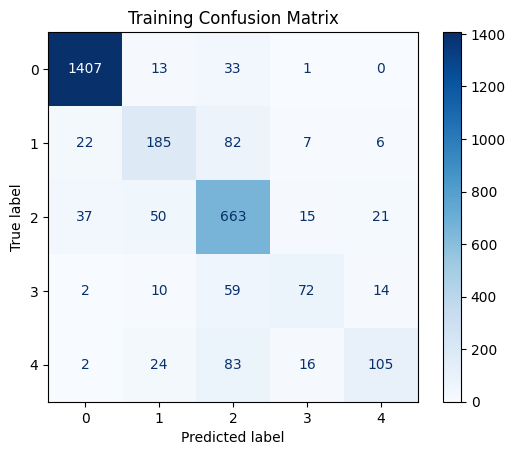

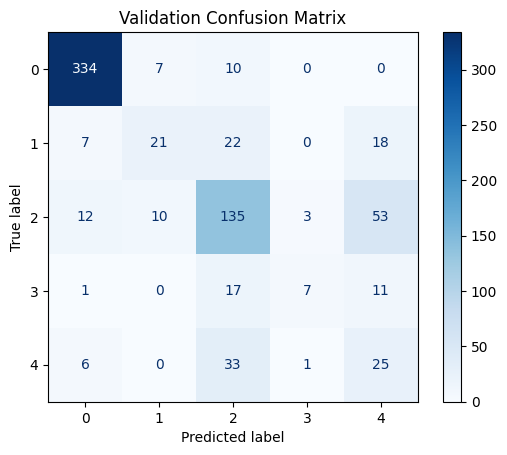

--- 295.0320682525635 seconds ---
Epoch 19: Train Loss: 0.474, Train Accuracy: 83.032%, Valid Loss: 0.767, Valid Accuracy: 71.214%
Train AUROC: 0.949, Train F1: 0.824%, Valid AUROC: 0.87, Valid F1: 0.71%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


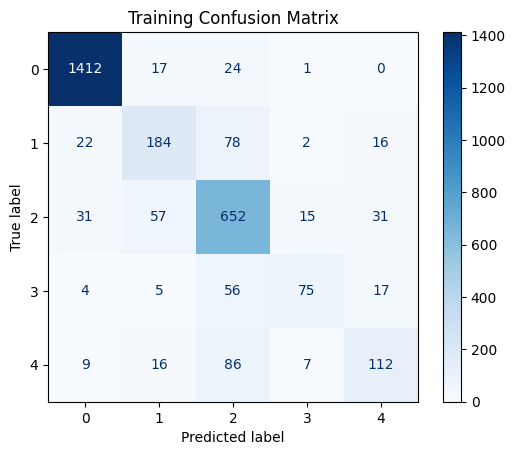

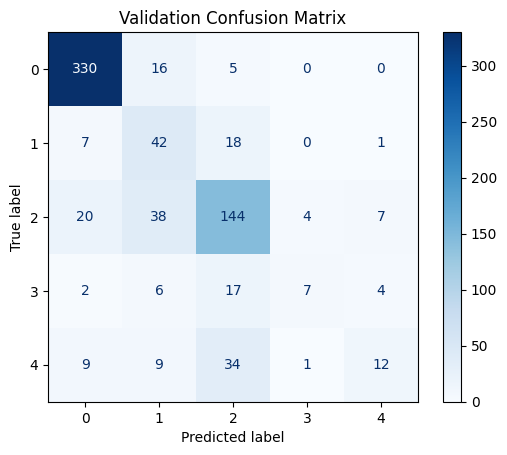

--- 297.6364734172821 seconds ---
Epoch 20: Train Loss: 0.426, Train Accuracy: 83.134%, Valid Loss: 0.794, Valid Accuracy: 72.988%
Train AUROC: 0.96, Train F1: 0.826%, Valid AUROC: 0.871, Valid F1: 0.716%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


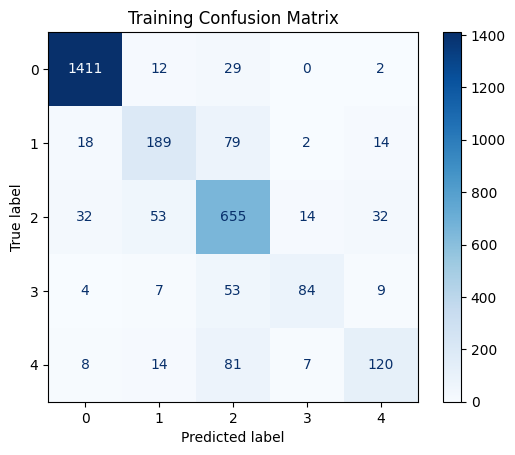

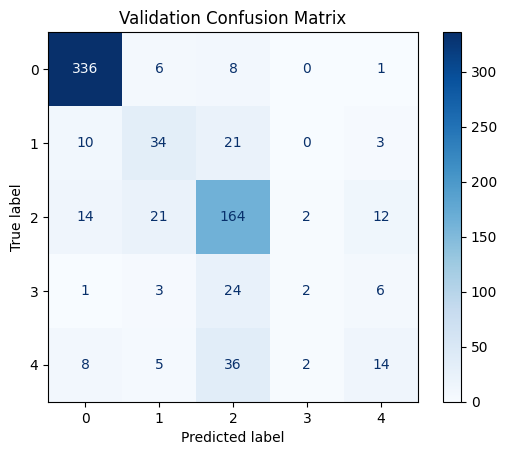

--- 290.69995045661926 seconds ---
Epoch 21: Train Loss: 0.427, Train Accuracy: 83.954%, Valid Loss: 0.771, Valid Accuracy: 75.034%
Train AUROC: 0.96, Train F1: 0.835%, Valid AUROC: 0.876, Valid F1: 0.727%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


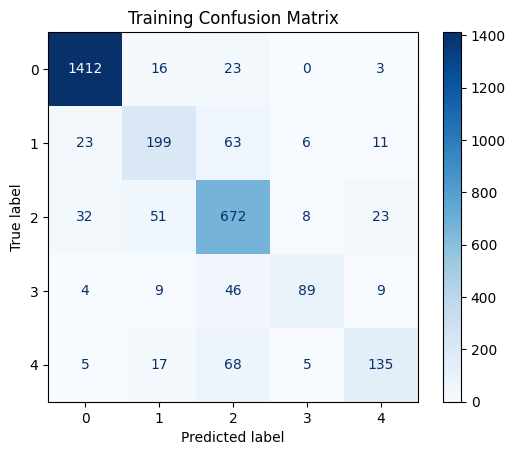

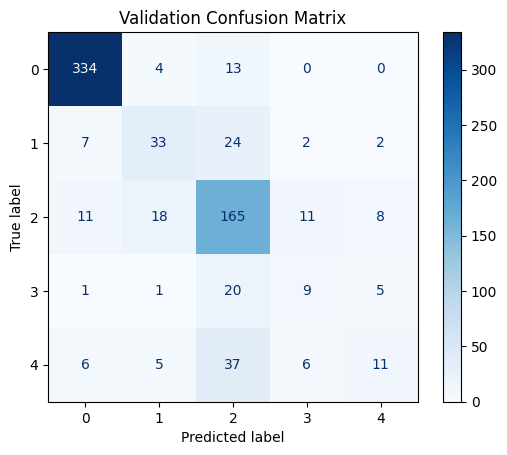

--- 292.9032189846039 seconds ---
Epoch 22: Train Loss: 0.384, Train Accuracy: 85.592%, Valid Loss: 0.736, Valid Accuracy: 75.307%
Train AUROC: 0.968, Train F1: 0.853%, Valid AUROC: 0.881, Valid F1: 0.736%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


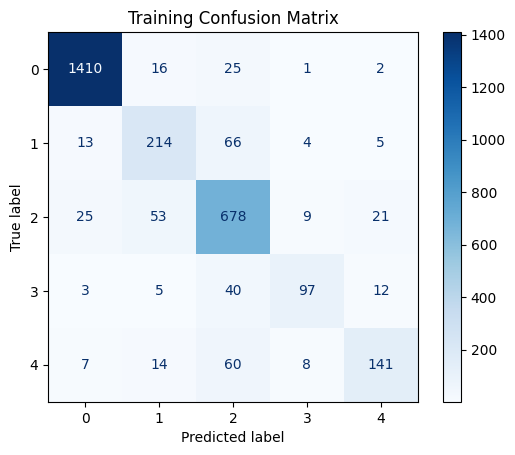

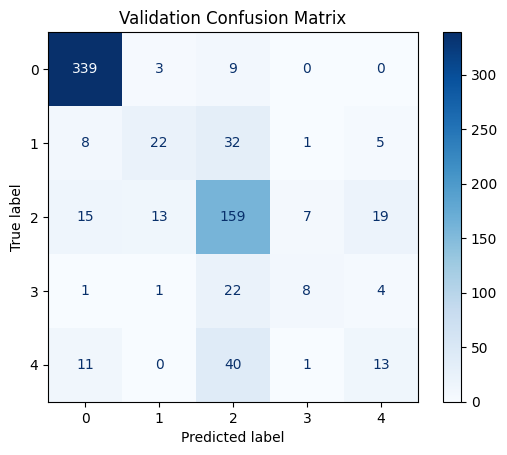

--- 298.40019178390503 seconds ---
Epoch 23: Train Loss: 0.362, Train Accuracy: 86.719%, Valid Loss: 0.78, Valid Accuracy: 73.806%
Train AUROC: 0.972, Train F1: 0.865%, Valid AUROC: 0.875, Valid F1: 0.717%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


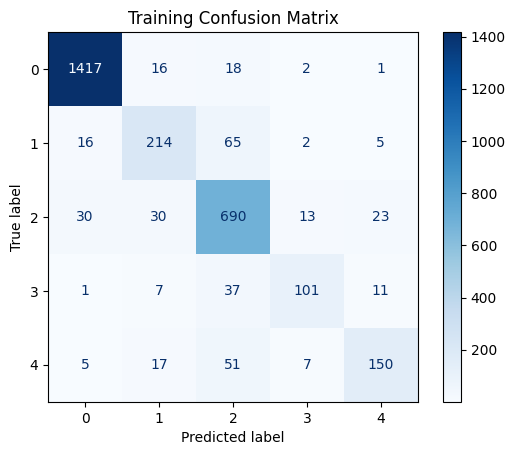

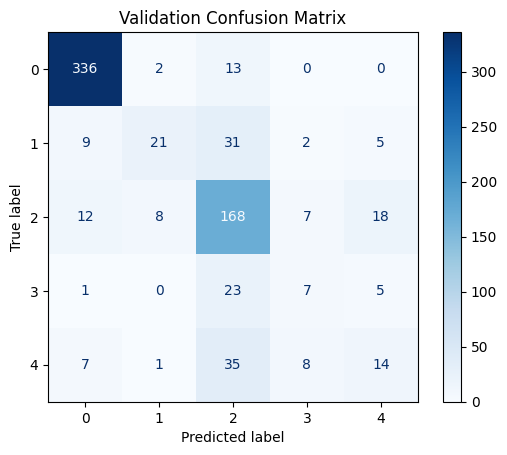

--- 297.38974618911743 seconds ---
Epoch 24: Train Loss: 0.328, Train Accuracy: 87.812%, Valid Loss: 0.847, Valid Accuracy: 74.488%
Train AUROC: 0.978, Train F1: 0.876%, Valid AUROC: 0.87, Valid F1: 0.725%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


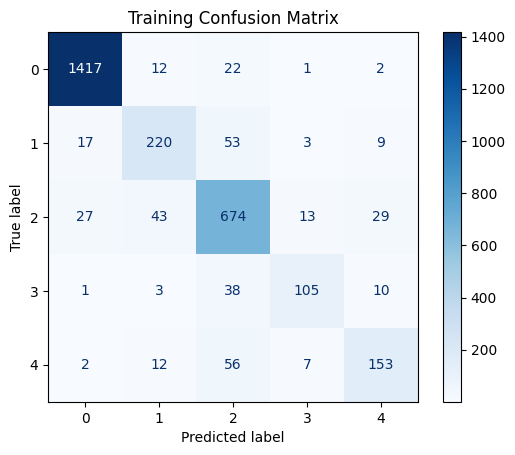

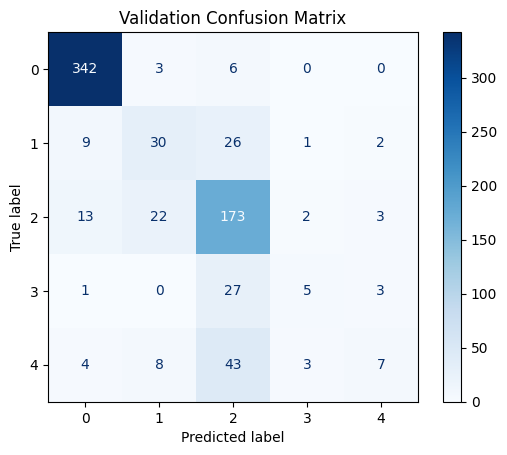

--- 299.16475677490234 seconds ---
Epoch 25: Train Loss: 0.337, Train Accuracy: 87.709%, Valid Loss: 0.917, Valid Accuracy: 75.989%
Train AUROC: 0.975, Train F1: 0.876%, Valid AUROC: 0.86, Valid F1: 0.729%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


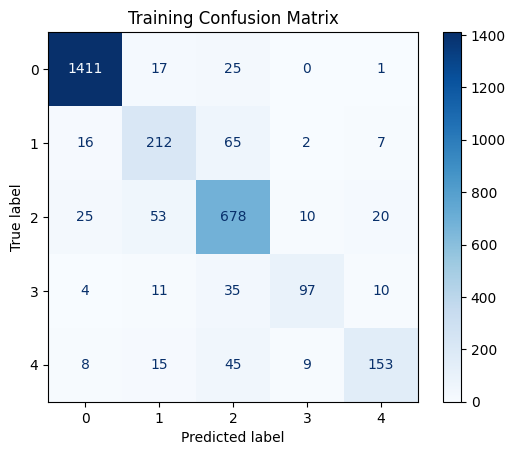

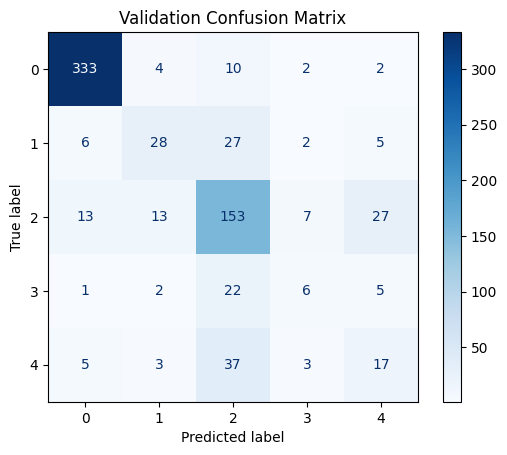

--- 301.28622174263 seconds ---
Epoch 26: Train Loss: 0.359, Train Accuracy: 87.095%, Valid Loss: 0.822, Valid Accuracy: 73.261%
Train AUROC: 0.972, Train F1: 0.869%, Valid AUROC: 0.859, Valid F1: 0.722%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


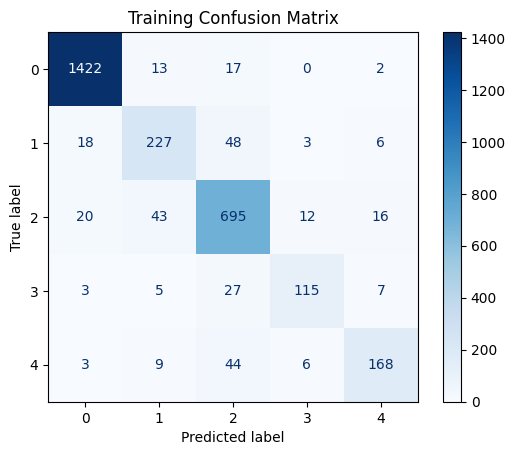

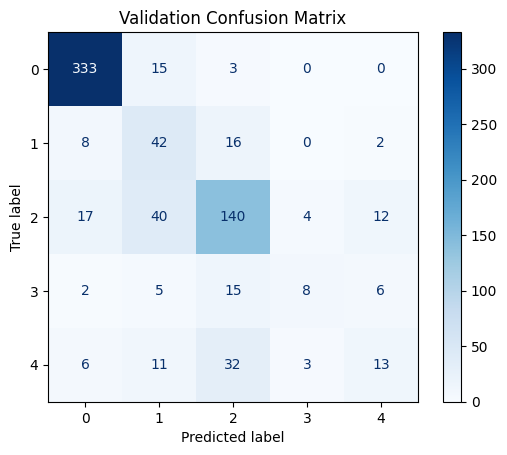

--- 292.1089701652527 seconds ---
Epoch 27: Train Loss: 0.288, Train Accuracy: 89.689%, Valid Loss: 0.903, Valid Accuracy: 73.124%
Train AUROC: 0.983, Train F1: 0.896%, Valid AUROC: 0.871, Valid F1: 0.721%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


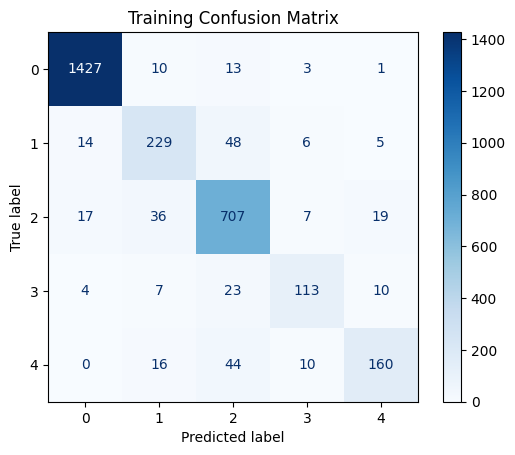

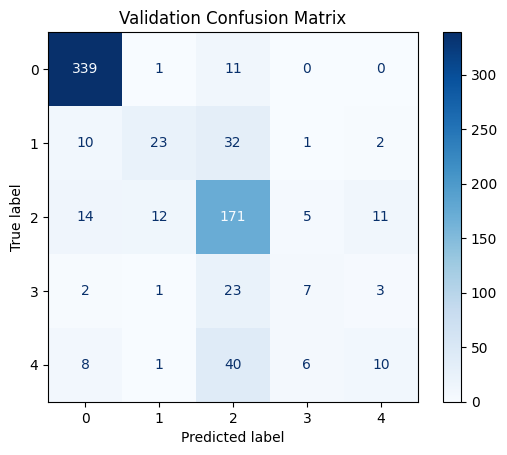

--- 291.46763586997986 seconds ---
Epoch 28: Train Loss: 0.286, Train Accuracy: 89.997%, Valid Loss: 0.911, Valid Accuracy: 75.034%
Train AUROC: 0.983, Train F1: 0.899%, Valid AUROC: 0.866, Valid F1: 0.723%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


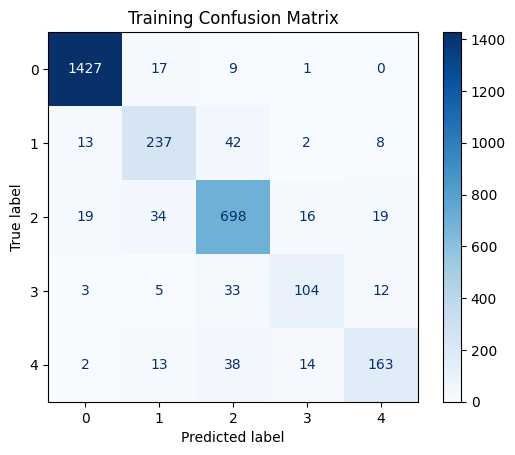

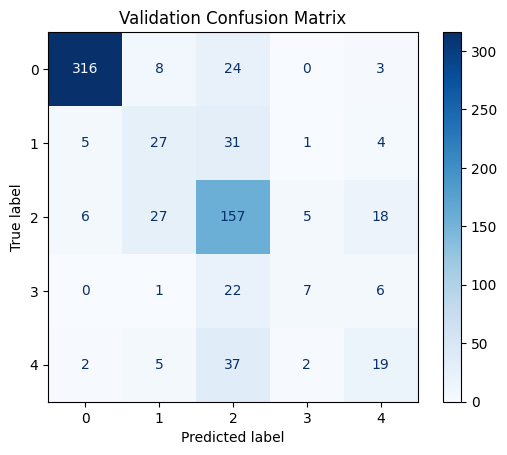

--- 301.0857963562012 seconds ---
Epoch 29: Train Loss: 0.291, Train Accuracy: 89.758%, Valid Loss: 0.917, Valid Accuracy: 71.76%
Train AUROC: 0.981, Train F1: 0.896%, Valid AUROC: 0.855, Valid F1: 0.713%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


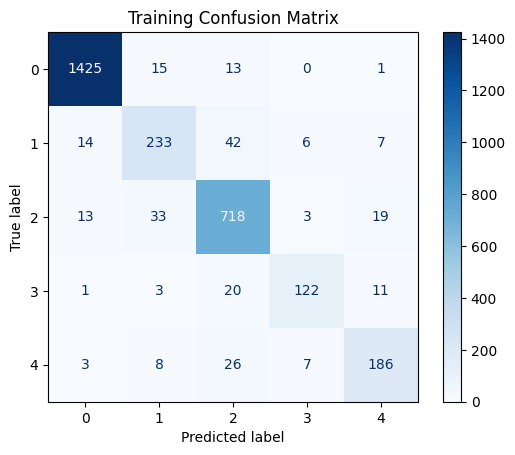

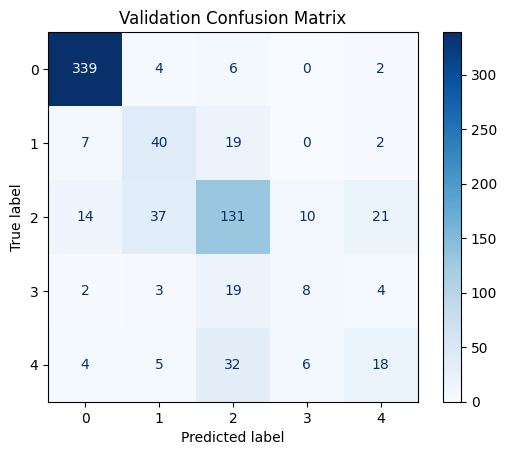

--- 294.1546700000763 seconds ---
Epoch 30: Train Loss: 0.239, Train Accuracy: 91.635%, Valid Loss: 0.903, Valid Accuracy: 73.124%
Train AUROC: 0.989, Train F1: 0.916%, Valid AUROC: 0.863, Valid F1: 0.723%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


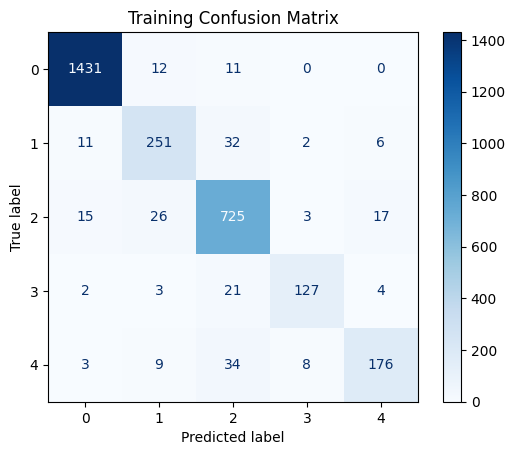

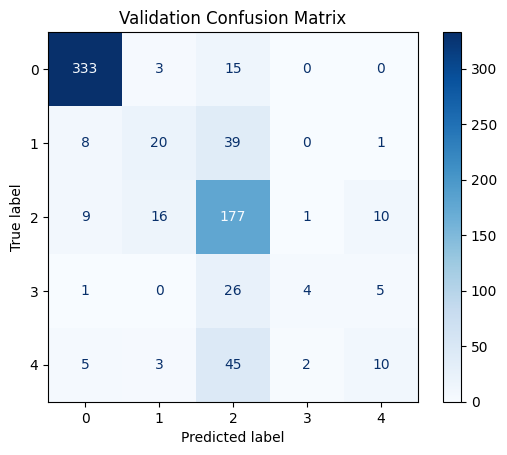

--- 288.37317991256714 seconds ---
Epoch 31: Train Loss: 0.219, Train Accuracy: 92.523%, Valid Loss: 1.059, Valid Accuracy: 74.216%
Train AUROC: 0.99, Train F1: 0.925%, Valid AUROC: 0.857, Valid F1: 0.713%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


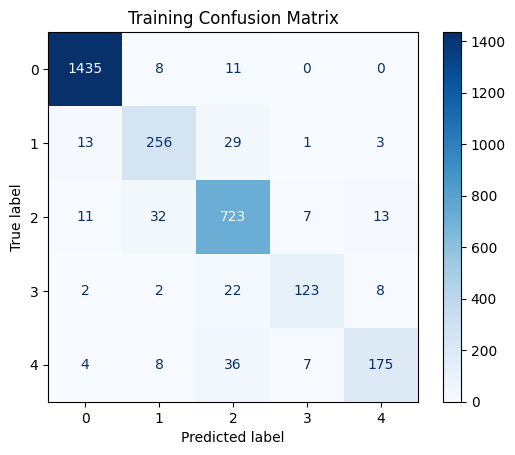

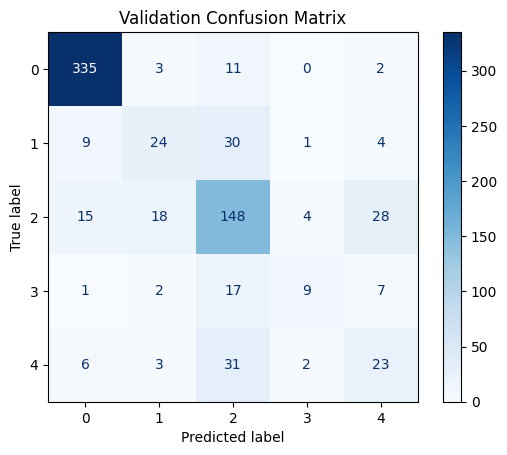

--- 288.9272665977478 seconds ---
Epoch 32: Train Loss: 0.206, Train Accuracy: 92.591%, Valid Loss: 0.933, Valid Accuracy: 73.533%
Train AUROC: 0.991, Train F1: 0.925%, Valid AUROC: 0.864, Valid F1: 0.725%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


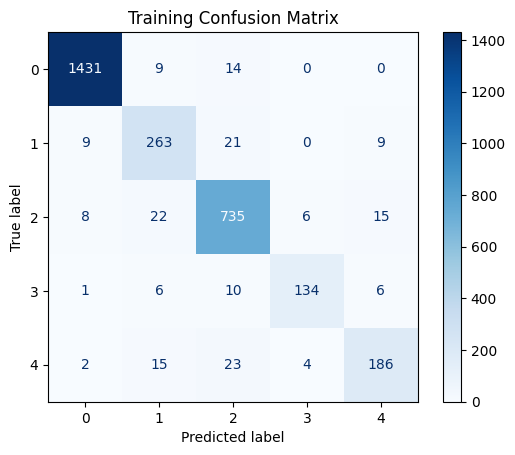

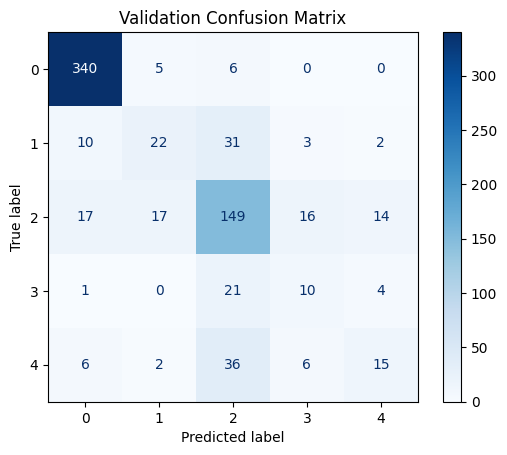

--- 281.63529920578003 seconds ---
Epoch 33: Train Loss: 0.187, Train Accuracy: 93.855%, Valid Loss: 1.002, Valid Accuracy: 73.124%
Train AUROC: 0.993, Train F1: 0.938%, Valid AUROC: 0.864, Valid F1: 0.715%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


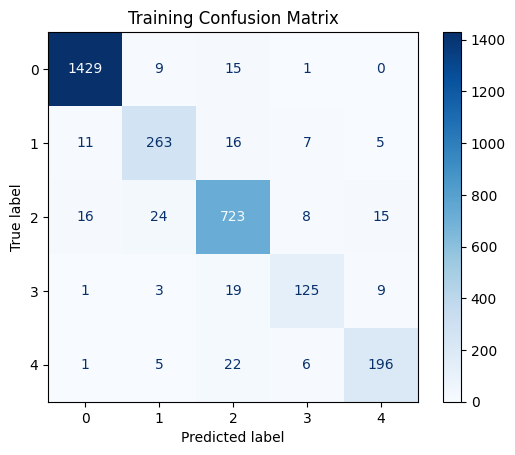

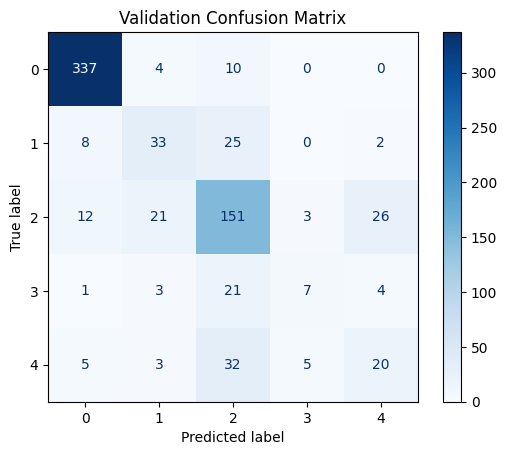

--- 294.0493309497833 seconds ---
Epoch 34: Train Loss: 0.182, Train Accuracy: 93.411%, Valid Loss: 1.054, Valid Accuracy: 74.761%
Train AUROC: 0.993, Train F1: 0.934%, Valid AUROC: 0.868, Valid F1: 0.736%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


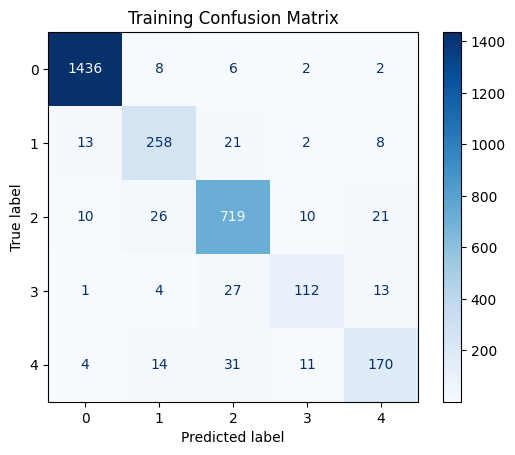

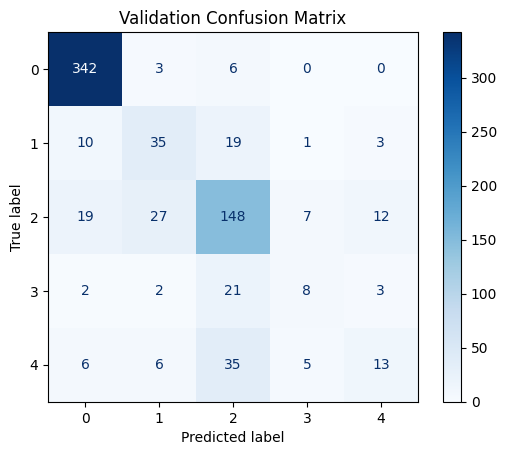

--- 291.85367608070374 seconds ---
Epoch 35: Train Loss: 0.237, Train Accuracy: 92.011%, Valid Loss: 1.029, Valid Accuracy: 74.488%
Train AUROC: 0.987, Train F1: 0.919%, Valid AUROC: 0.857, Valid F1: 0.727%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


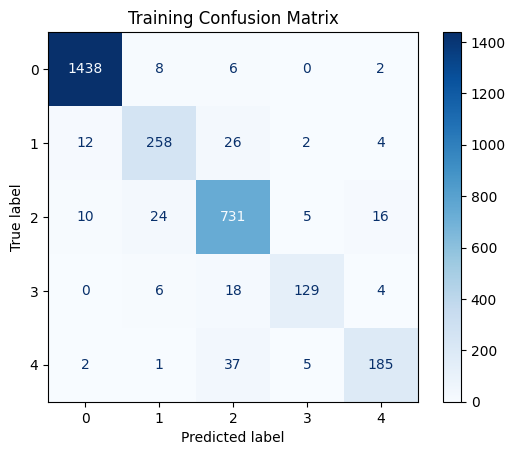

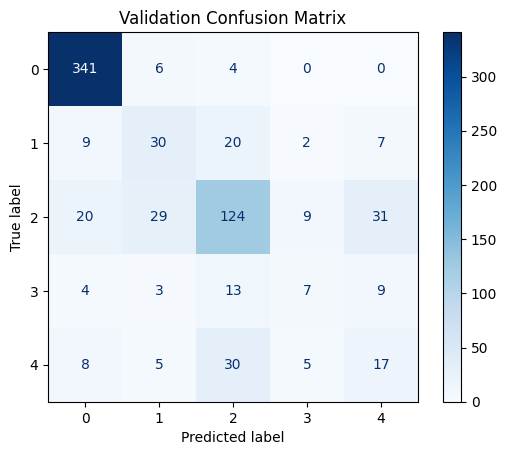

--- 296.01930928230286 seconds ---
Epoch 36: Train Loss: 0.188, Train Accuracy: 93.581%, Valid Loss: 1.041, Valid Accuracy: 70.805%
Train AUROC: 0.993, Train F1: 0.935%, Valid AUROC: 0.86, Valid F1: 0.698%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


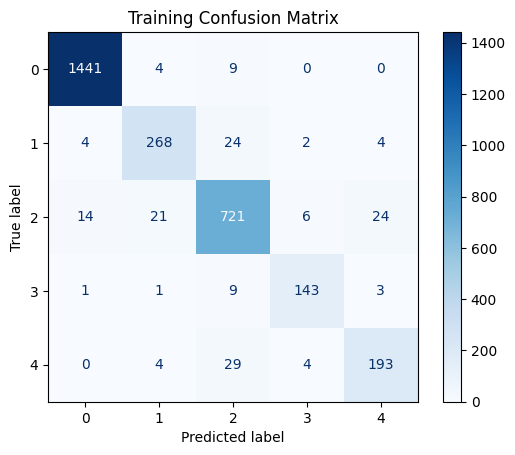

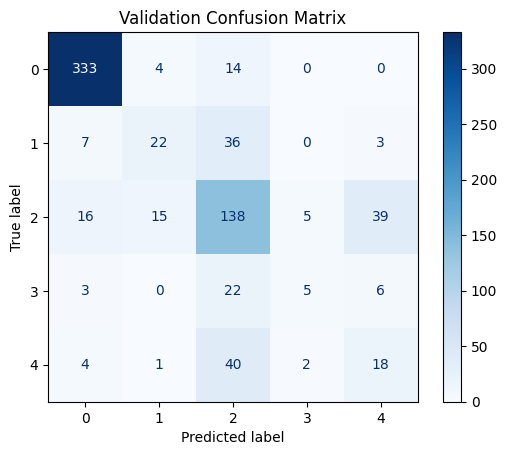

--- 302.74831438064575 seconds ---
Epoch 37: Train Loss: 0.168, Train Accuracy: 94.435%, Valid Loss: 0.998, Valid Accuracy: 70.396%
Train AUROC: 0.994, Train F1: 0.944%, Valid AUROC: 0.855, Valid F1: 0.692%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


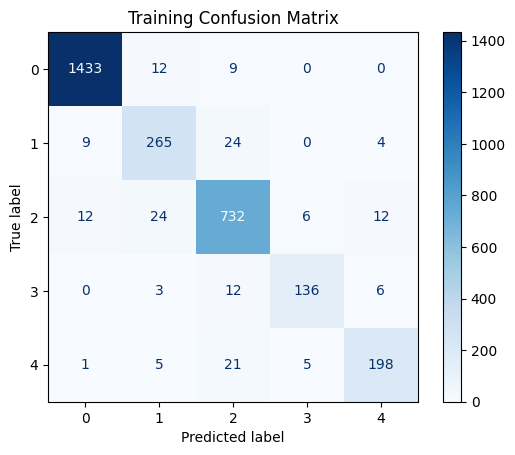

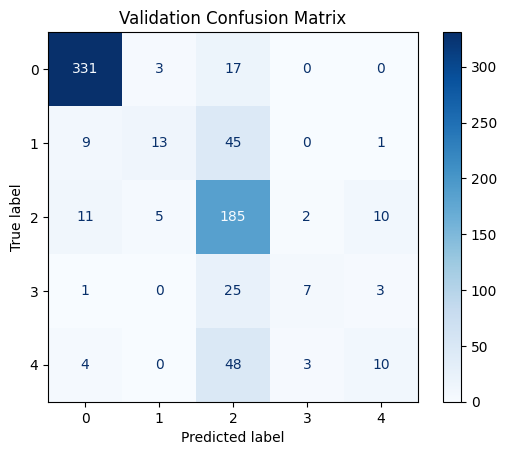

--- 291.79343008995056 seconds ---
Epoch 38: Train Loss: 0.163, Train Accuracy: 94.367%, Valid Loss: 1.204, Valid Accuracy: 74.488%
Train AUROC: 0.994, Train F1: 0.944%, Valid AUROC: 0.849, Valid F1: 0.711%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


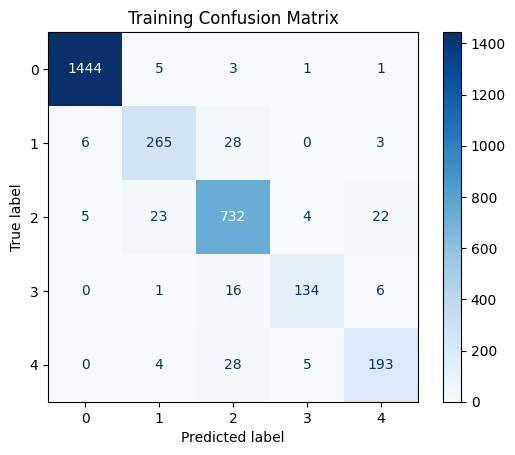

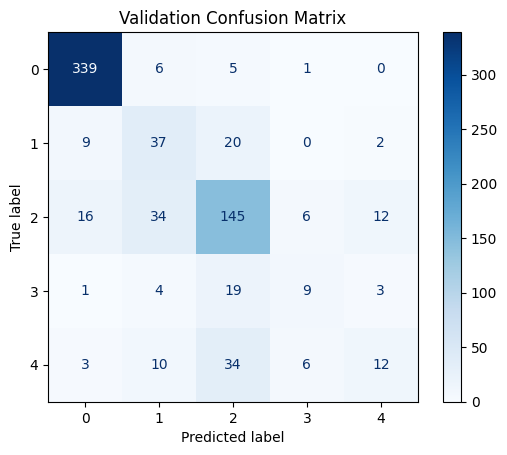

--- 284.2128565311432 seconds ---
Epoch 39: Train Loss: 0.161, Train Accuracy: 94.503%, Valid Loss: 1.037, Valid Accuracy: 73.943%
Train AUROC: 0.994, Train F1: 0.945%, Valid AUROC: 0.871, Valid F1: 0.726%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


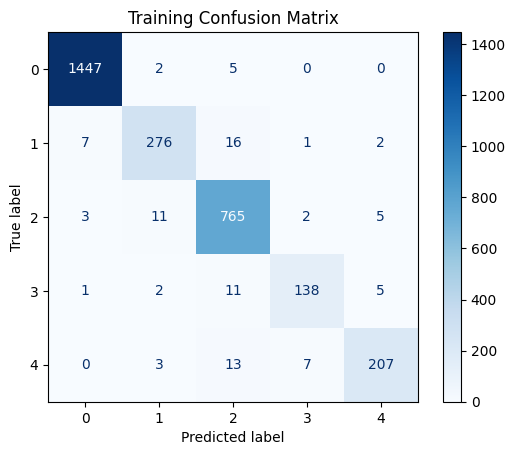

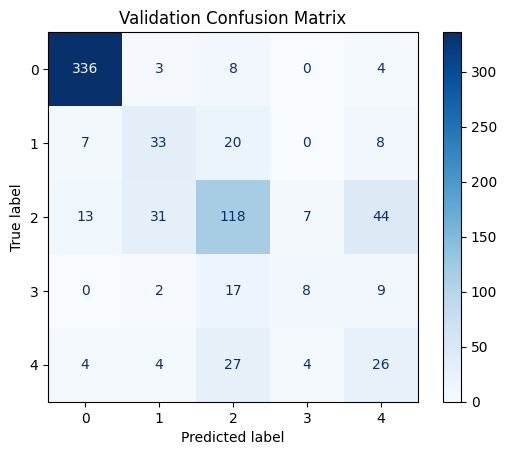

--- 292.4342143535614 seconds ---
Epoch 40: Train Loss: 0.116, Train Accuracy: 96.722%, Valid Loss: 1.054, Valid Accuracy: 71.078%
Train AUROC: 0.997, Train F1: 0.967%, Valid AUROC: 0.864, Valid F1: 0.71%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


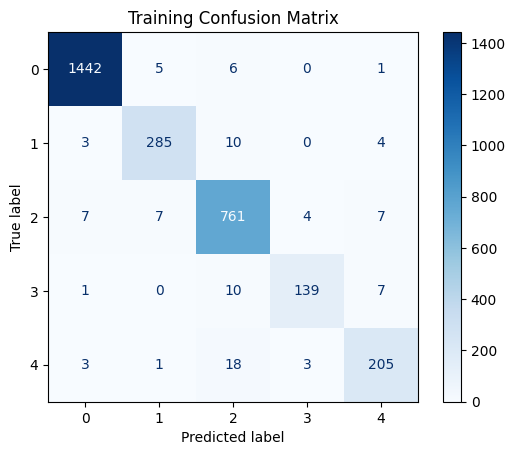

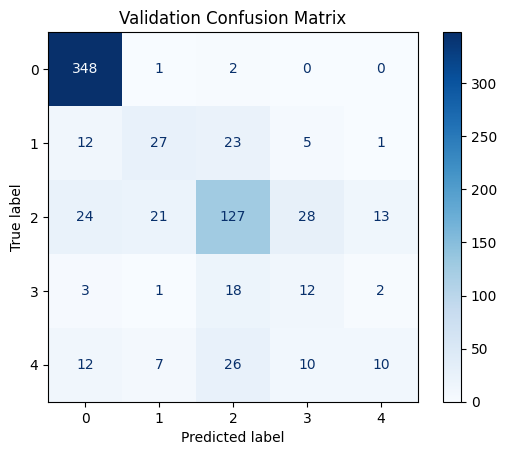

--- 295.75182127952576 seconds ---
Epoch 41: Train Loss: 0.114, Train Accuracy: 96.688%, Valid Loss: 1.242, Valid Accuracy: 71.487%
Train AUROC: 0.997, Train F1: 0.967%, Valid AUROC: 0.859, Valid F1: 0.697%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


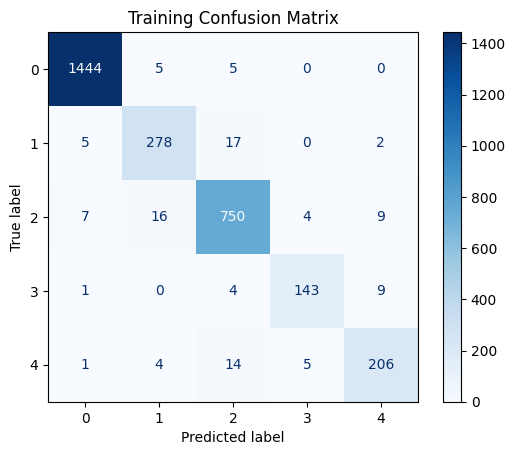

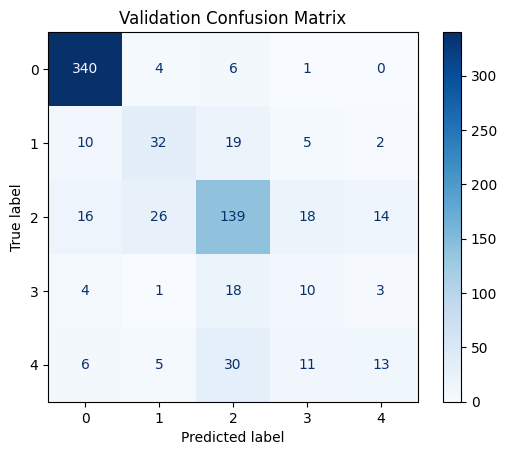

--- 299.0002553462982 seconds ---
Epoch 42: Train Loss: 0.127, Train Accuracy: 96.313%, Valid Loss: 1.089, Valid Accuracy: 72.851%
Train AUROC: 0.996, Train F1: 0.963%, Valid AUROC: 0.862, Valid F1: 0.718%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


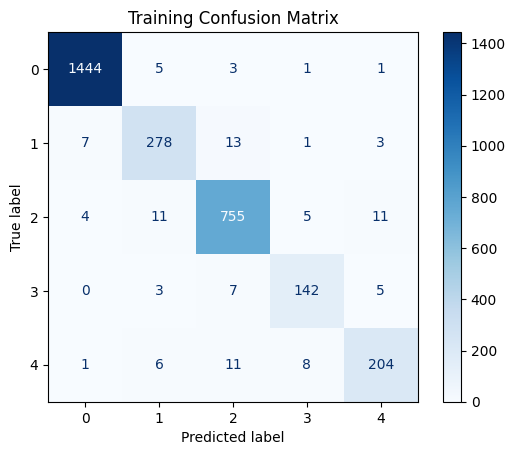

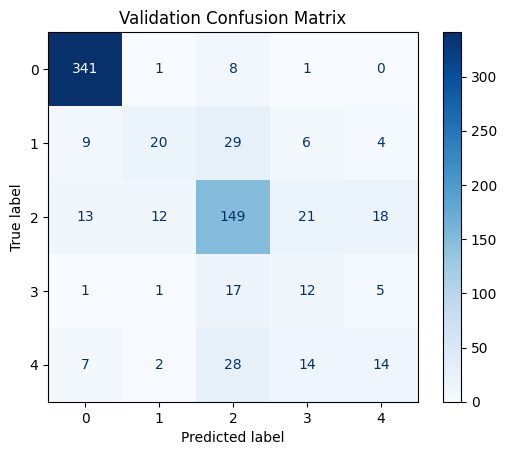

--- 299.73563146591187 seconds ---
Epoch 43: Train Loss: 0.114, Train Accuracy: 96.381%, Valid Loss: 1.164, Valid Accuracy: 73.124%
Train AUROC: 0.997, Train F1: 0.964%, Valid AUROC: 0.865, Valid F1: 0.72%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


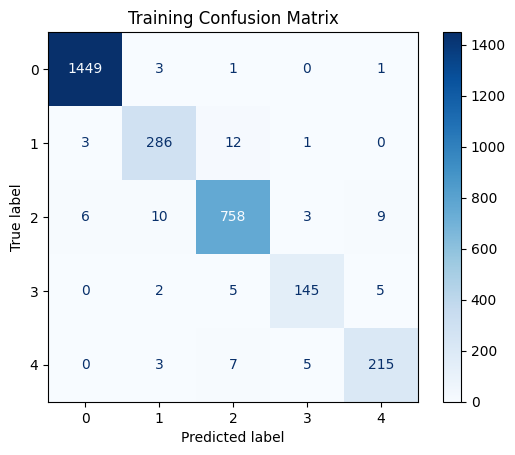

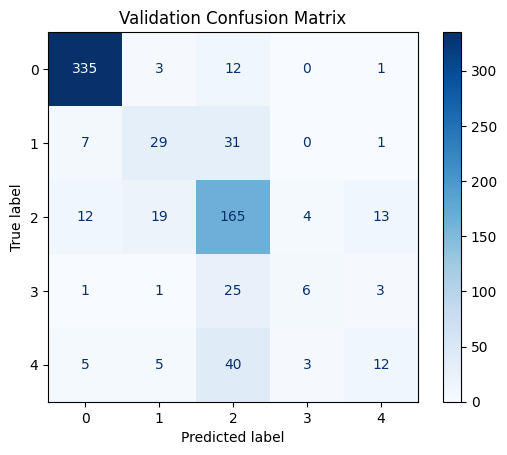

--- 293.4877669811249 seconds ---
Epoch 44: Train Loss: 0.087, Train Accuracy: 97.405%, Valid Loss: 1.381, Valid Accuracy: 74.625%
Train AUROC: 0.999, Train F1: 0.974%, Valid AUROC: 0.846, Valid F1: 0.726%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


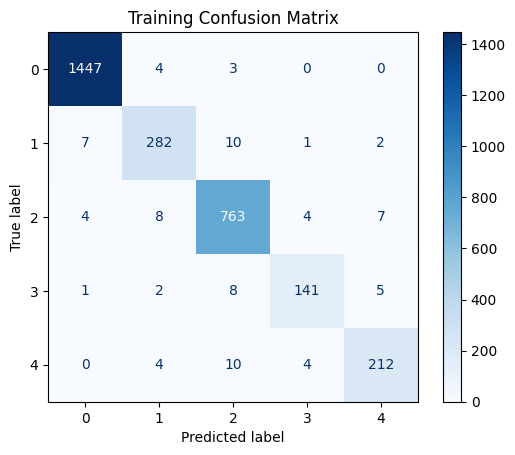

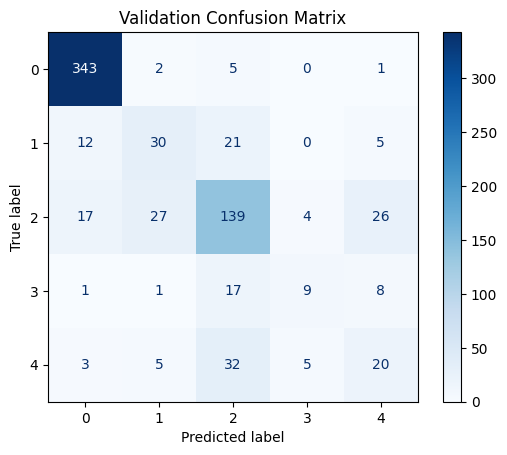

--- 294.09330558776855 seconds ---
Epoch 45: Train Loss: 0.093, Train Accuracy: 97.132%, Valid Loss: 1.075, Valid Accuracy: 73.806%
Train AUROC: 0.998, Train F1: 0.971%, Valid AUROC: 0.87, Valid F1: 0.728%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


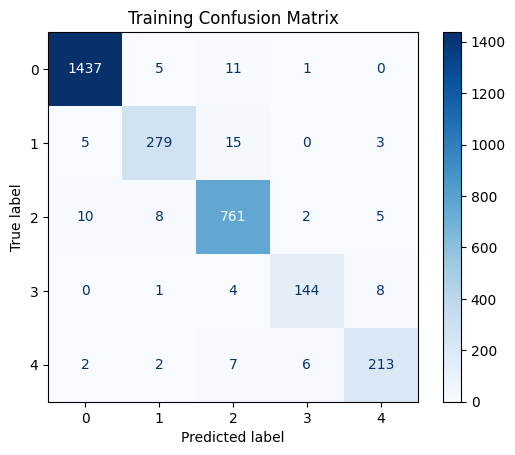

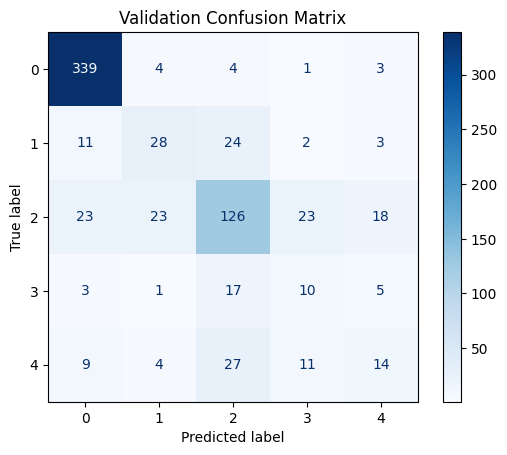

--- 300.25682950019836 seconds ---
Epoch 46: Train Loss: 0.115, Train Accuracy: 96.757%, Valid Loss: 1.23, Valid Accuracy: 70.532%
Train AUROC: 0.997, Train F1: 0.968%, Valid AUROC: 0.859, Valid F1: 0.695%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


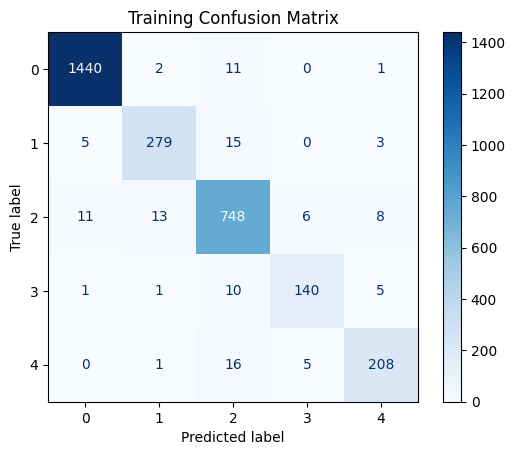

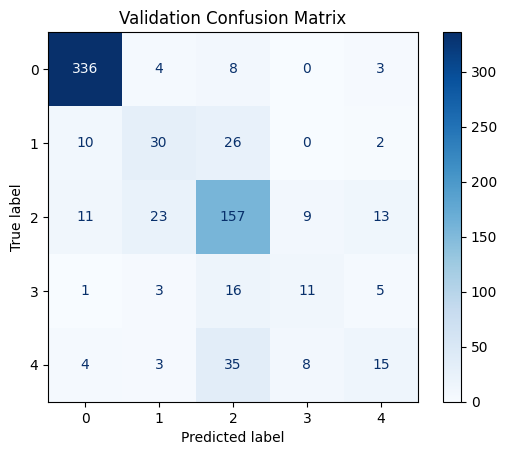

--- 300.6709997653961 seconds ---
Epoch 47: Train Loss: 0.124, Train Accuracy: 96.108%, Valid Loss: 1.054, Valid Accuracy: 74.898%
Train AUROC: 0.996, Train F1: 0.961%, Valid AUROC: 0.87, Valid F1: 0.737%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


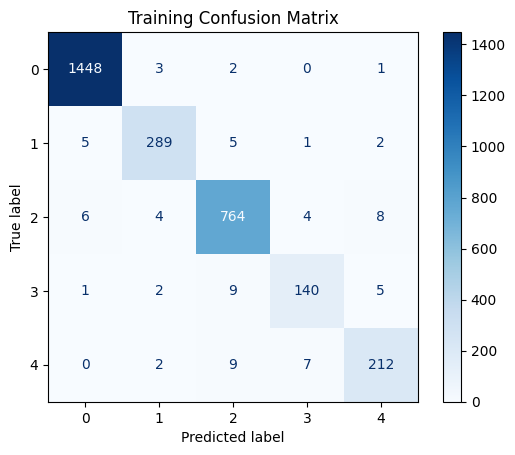

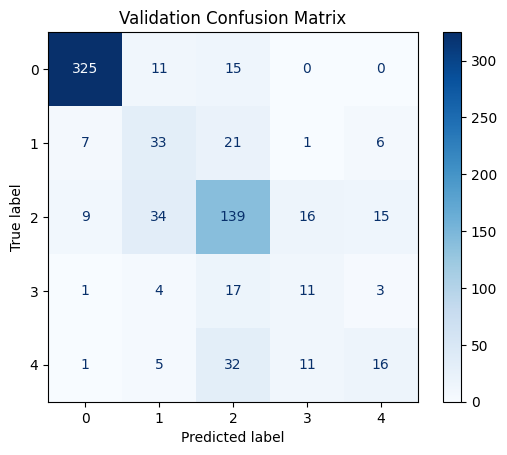

--- 297.46619725227356 seconds ---
Epoch 48: Train Loss: 0.082, Train Accuracy: 97.405%, Valid Loss: 1.145, Valid Accuracy: 71.487%
Train AUROC: 0.998, Train F1: 0.974%, Valid AUROC: 0.862, Valid F1: 0.714%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


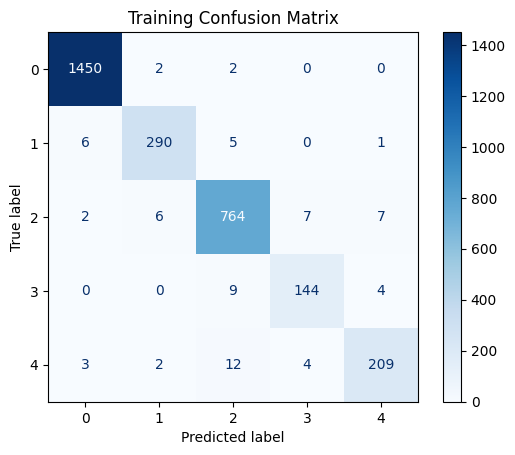

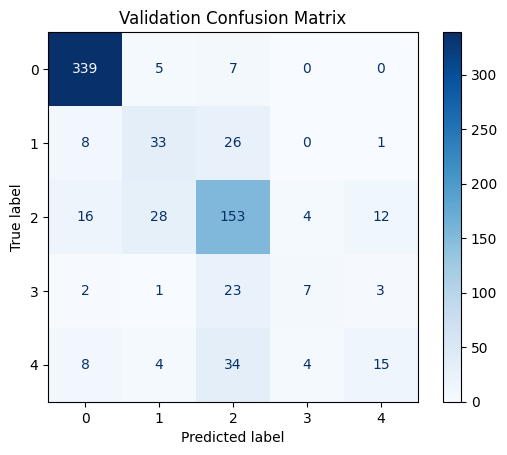

--- 290.648313999176 seconds ---
Epoch 49: Train Loss: 0.094, Train Accuracy: 97.542%, Valid Loss: 1.246, Valid Accuracy: 74.625%
Train AUROC: 0.997, Train F1: 0.975%, Valid AUROC: 0.865, Valid F1: 0.729%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


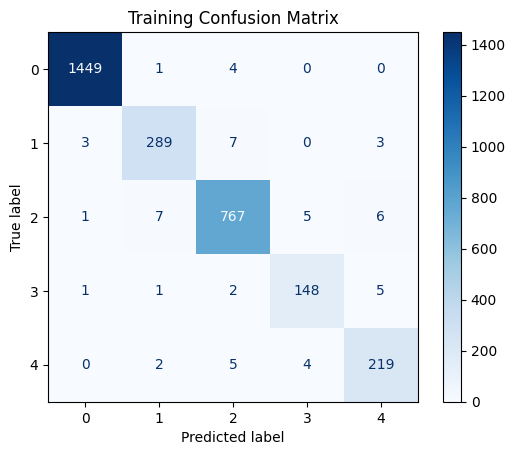

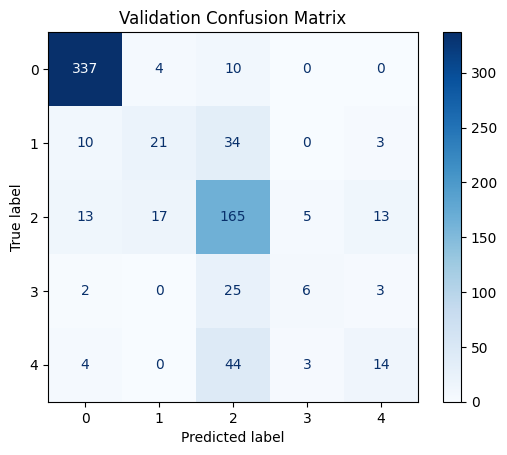

--- 300.3801414966583 seconds ---
Epoch 50: Train Loss: 0.076, Train Accuracy: 98.054%, Valid Loss: 1.299, Valid Accuracy: 74.079%
Train AUROC: 0.998, Train F1: 0.981%, Valid AUROC: 0.856, Valid F1: 0.718%


In [18]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import time


def train(model, train_loader, valid_loader, criterion, optimizer, epochs=1):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_f1s, valid_f1s = [], []
    train_auc_scores, train_aurocs = [], []
    valid_auc_scores, valid_aurocs = [], []
    train_tp, train_tn, train_fp, train_fn = [], [], [], []
    valid_tp, valid_tn, valid_fp, valid_fn = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        all_train_labels, all_train_preds = [], []
        start_time = time.time()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect data for AUROC and F1 score
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)

        # Calculate confusion matrix and TP, TN, FP, FN
        cm = confusion_matrix(all_train_labels, np.argmax(all_train_preds, axis=1), labels=list(range(6)))
        tp, fn, fp, tn = calculate_tp_fn_fp_tn(cm)
        train_tp.append(tp)
        train_tn.append(tn)
        train_fp.append(fp)
        train_fn.append(fn)

        # Calculate AUROC and F1 score
        all_train_labels = np.array(all_train_labels)
        all_train_preds = np.array(all_train_preds)
        train_auroc = roc_auc_score(all_train_labels, all_train_preds, multi_class='ovr') if len(np.unique(all_train_labels)) > 1 else float('nan')
        train_f1 = f1_score(all_train_labels, np.argmax(all_train_preds, axis=1), average='weighted')

        # Add to lists
        train_aurocs.append(train_auroc)
        train_f1s.append(train_f1)

        # VALIDATION STEPS
        valid_loss, valid_accuracy, valid_auroc, valid_f1, valid_labels, valid_preds = validate(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        valid_aurocs.append(valid_auroc)
        valid_f1s.append(valid_f1)

        # Plot confusion matrices
        plot_confusion_matrix(np.array(all_train_labels), np.argmax(np.array(all_train_preds), axis=1), title='Training Confusion Matrix')
        plot_confusion_matrix(np.array(valid_labels), np.argmax(np.array(valid_preds), axis=1), title='Validation Confusion Matrix')

        curr = time.ctime(time.time())
        print("--- %s seconds ---" % (time.time() - start_time))
        print(f"Epoch {epoch+1}: Train Loss: {round(train_loss, 3)}, Train Accuracy: {round(train_accuracy, 3)}%, Valid Loss: {round(valid_loss, 3)}, Valid Accuracy: {round(valid_accuracy, 3)}%")
        print(f"Train AUROC: {round(train_auroc, 3)}, Train F1: {round(train_f1, 3)}%, Valid AUROC: {round(valid_auroc, 3)}, Valid F1: {round(valid_f1, 3)}%")

    return (train_losses, valid_losses, train_accuracies, valid_accuracies,
            train_aurocs, valid_aurocs,
            train_tp, train_tn, train_fp, train_fn,
            valid_tp, valid_tn, valid_fp, valid_fn)

def validate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_valid_labels, all_valid_preds = [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect data for AUROC and F1 score
            all_valid_labels.extend(labels.cpu().numpy())
            all_valid_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total

    # Calculate AUROC and F1 score
    all_valid_labels = np.array(all_valid_labels)
    all_valid_preds = np.array(all_valid_preds)
    valid_f1 = f1_score(all_valid_labels, np.argmax(all_valid_preds, axis=1), average='weighted')
    valid_auroc = roc_auc_score(all_valid_labels, all_valid_preds, multi_class='ovr') if len(np.unique(all_valid_labels)) > 1 else float('nan')

    # Calculate confusion matrix and TP, TN, FP, FN
    cm = confusion_matrix(all_valid_labels, np.argmax(all_valid_preds, axis=1), labels=list(range(6)))
    valid_tp, valid_fn, valid_fp, valid_tn = calculate_tp_fn_fp_tn(cm)

    return valid_loss, valid_accuracy, valid_auroc, valid_f1, all_valid_labels, all_valid_preds

def calculate_tp_fn_fp_tn(cm):
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    return tp, fn, fp, tn

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(5)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(5)))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies, train_aurocs, valid_aurocs, train_tp, train_tn, train_fp, train_fn, valid_tp, valid_tn, valid_fp, valid_fn = train(model, trainloader, validloader, criterion, optimizer, epochs=50)


In [19]:
torch.save(model, 'Model_CNN_FocalLossNormal.pt')

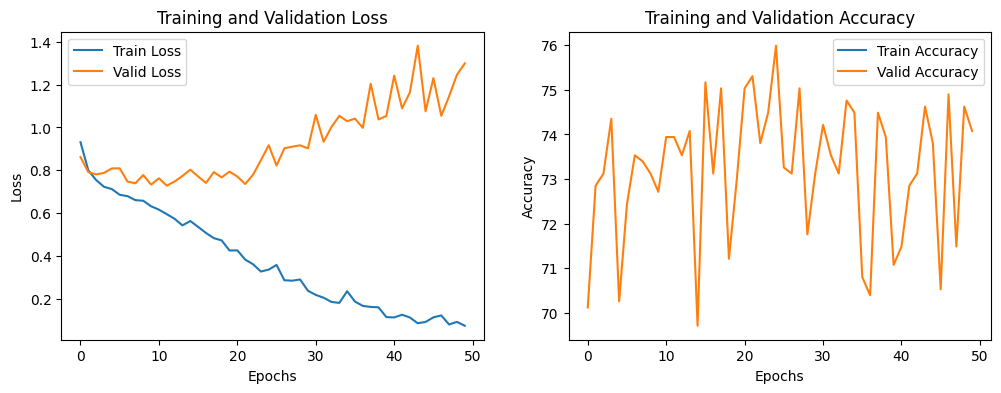

In [20]:
6# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()